In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import spearmanr,pearsonr
import sys
from math import log10
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from scipy import stats
from csv import writer 

In [92]:
def get_selected_prs(target, method):
    sig_prs = pd.read_csv('4manuscript\Significant_proteins.csv')
    all_prts = pd.read_csv('4manuscript\NAME_OID.csv')
    sig_prs_oid = all_prts[all_prts['name'].isin(sig_prs['%s_proteins'%target].values.tolist())]['OID'].values.tolist()
    high_cor_prs = sig_prs[((sig_prs['sis3_correlations'].abs()).ge(0.3)) & (sig_prs['sis3_pvalue'].le(0.05))]
    high_cor_oid = all_prts[all_prts['name'].isin(high_cor_prs['%s_proteins'%target].values.tolist())]['OID'].values.tolist()
    if method == 'sig':
        return sig_prs_oid  
    if method == 'high_corr':
        return high_cor_oid 
    return 

In [87]:
def fs_func(target, data, add_fea, method):
    feat1 = get_selected_prs(target, method)
    feat1 = [f for f in feat1 if f in data]
    feat2 = add_fea
    k_feas = []
    k_feas.extend(feat1)
    k_feas.extend(feat2)
    return k_feas  

In [89]:
NPX_data_V2 = pd.read_csv('4manuscript\C_NPX_data.csv')
NPX_data_V2 = NPX_data_V2.dropna(axis=1)
patient_data_v2 = pd.read_csv('4manuscript\C_patient_data.csv')

In [78]:
target = ['sis3'] #['facit']
add_fea = ['age','timesince']#,'size','gender','nihss',]#,
str_add_fea = 'pr +' + '+ '.join(add_fea)
print(str_add_fea)

y_data_features = []
y_data_features.extend(add_fea)
y_data_features.extend(target)
y_data_features.extend(['pid'])
y_data = patient_data_v2.dropna(subset=target)
y_data = y_data[y_data_features] #'size','timesince','age',
y_data = y_data.dropna(subset=add_fea)

X = NPX_data_V2

data = y_data.merge(X,how='inner', on='pid')

selected_features = [col for col in NPX_data_V2 if 'OID' in col]
print(len(selected_features))
selected_features.extend(add_fea)
pids = set(data['pid'].values.tolist())   
print(len(selected_features))
print(add_fea)
data.info()

pr +age+ timesince
1011
1013
['age', 'timesince']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 84
Columns: 1015 entries, age to OID01119
dtypes: float64(1014), int64(1)
memory usage: 674.7 KB


In [88]:
model = LogisticRegression(fit_intercept=True)
tru_vals = []
predictions = []
fs_method = 'sig' #'high_corr'#  'no filter'# 
x_shape = len(selected_features)
for i,p in enumerate(list(pids)):
    if fs_method == 'no filter':
        new_selected_features = selected_features
    else:
        new_selected_features = fs_func(target[0], data, add_fea, fs_method)
    x_tr = data[data['pid']!=p][new_selected_features].values.reshape(-1, len(new_selected_features))
    y_tr = data[data['pid']!=p][target].values.reshape(-1, 1)
    x_te = data[data['pid']==p][new_selected_features].values.reshape(-1, len(new_selected_features))
    y_te = data[data['pid']==p][target].values.reshape(-1, 1)
    tru_vals.extend(y_te.flatten())
    model.fit(x_tr, y_tr)
    y_pred = model.predict(x_te)
    predictions.extend(y_pred)

In [83]:
List = [type(model).__name__, fs_method+str_add_fea, target,  spearmanr(predictions, tru_vals)[0], spearmanr(predictions, tru_vals)[1],  -log10(spearmanr(predictions, tru_vals)[1])]
#file_name = 'FS/kristy_FS_%s_pvals_ipython2.csv'%target[0]
file_name = 'test.csv'
with open('test/%s'%file_name, 'a') as f_object: 
    writer_object = writer(f_object) 
    writer_object.writerow(List) 
    f_object.close()

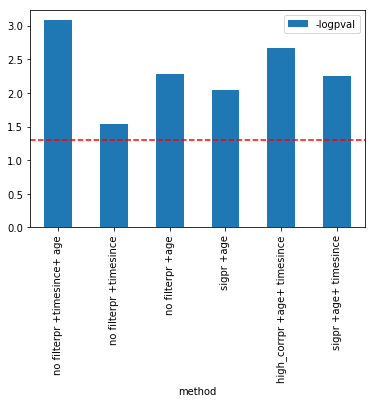

In [94]:
p = pd.read_csv('test/%s'%file_name, names=[ 'model', 'method', 'target', 'corr', 'pval', '-logpval'])
p.plot.bar(x='method', y='-logpval', rot=90)
plt.axhline(y=-log10(0.05), color='r', linestyle='--')
plt.show()